# Neural Transition-Based Parsing for Unlabeled Dependency Grammars in Spanish using the Arc-Eager Parsing Algorithm

Natural Language Processing, University of Padua, 2022-23.

Jesús Moncada Ramírez (2075280).

## 1. Introduction

This project aims to use a **neural transition-based parser** to analyze unlabelled dependencies through dependency parsing.
Specifically, we will explore the **arc-eager** parsing algorithm and its implementation using a static oracle.
We have developed **two neural models**: (1) a baseline model utilizing a Bi-LSTM and (2) a more advanced model based on BERT.
To train these models we have used a dependency treebank from the Universal Dependency project **in Spanish**, called [es/ancora](https://huggingface.co/datasets/PlanTL-GOB-ES/UD_Spanish-AnCora).

Through this research, we aim to improve our understanding of dependency parsing and contribute to the advancement of Natural Language Processing techniques.

First of all, let's install and import some libraries.

In [1]:
# INSTALL SECTION
!pip install transformers # huggingface library for bert and bert tokenizers
!pip install datasets     # huggingface library for datasets
!pip install conllu       # aux library for processing CoNLL-U format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# IMPORT SECTION
import os

import numpy as np

from functools import partial

import torch
import torch.nn as nn

from datasets import load_dataset

import matplotlib.pyplot as plt

from tabulate import tabulate

from tqdm.notebook import tqdm

from transformers import BertModel, BertTokenizer, BertForMaskedLM

import pickle

We will also mount this Notebook in Google Drive to save/load our trained models. Comment the following cell if not running on Google Colab.

In [3]:
# IMPORTANT: comment if not running on Google Colab.
from google.colab import drive
drive_path = '/content/drive'
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Dataset analysis

As specified in the project statement the dataset is a dependency treebank from the Universal Dependency project. We will manage it using the Hugging Face ``datasets`` library. Specifically, we will use the ``es_ancora`` subset, whose language is Spanish. More information [here](https://huggingface.co/datasets/universal_dependencies/viewer/es_ancora/train).

In [4]:
dataset_ori = load_dataset('universal_dependencies', 'es_ancora')

  0%|          | 0/3 [00:00<?, ?it/s]

Let's print some information about the dataset. For every split (train, validation, and test) we will plot the sentence length distribution. Furthermore, we will present some metrics such as the number of samples, and the maximum, minimum, and mean sentence length.

╒══════════════════════╤═════════╤══════════════╤═════════╕
│ Measure              │   train │   validation │    test │
╞══════════════════════╪═════════╪══════════════╪═════════╡
│ Number of instances  │   14305 │         1654 │    1721 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length mean │  31.188 │      31.7479 │ 30.6804 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length max  │     150 │          115 │     133 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length min  │       1 │            2 │       2 │
╘══════════════════════╧═════════╧══════════════╧═════════╛


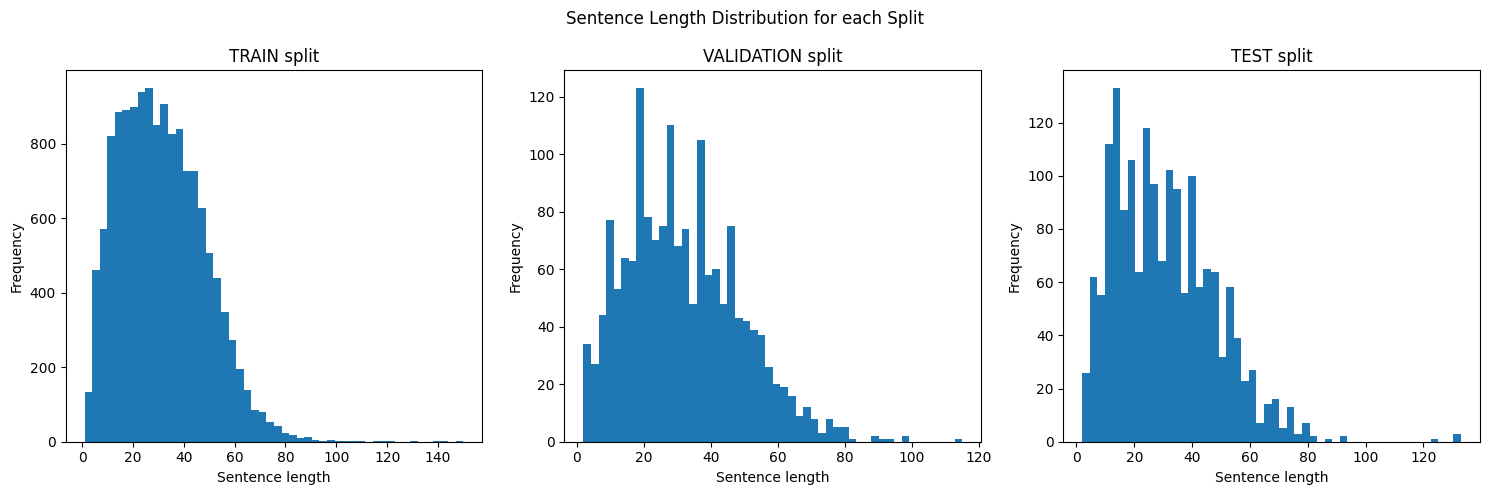

In [5]:
def dataset_statistics_by_splits(splits, dataset, show_plot=False):

  if show_plot:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

  row_headers = ['Measure'] + splits
  row_number = ['Number of instances']
  row_mean = ['Sentence length mean']
  row_max = ['Sentence length max']
  row_min = ['Sentence length min']

  for i, split_name in enumerate(splits):
    split_data = dataset[split_name]

    # Basic info
    row_number.append(len(split_data))

    # Sentence length distribution
    sentence_lengths = [len(example['tokens']) for example in split_data]

    # Sentence length mean, max, min
    row_mean.append(np.mean(sentence_lengths))
    row_max.append(np.max(sentence_lengths))
    row_min.append(np.min(sentence_lengths))

    # Show sentence length distribution chart
    if show_plot:
      axs[i].hist(sentence_lengths, bins=min(50, len(sentence_lengths)))
      axs[i].set_title(f'{split_name.upper()} split')
      axs[i].set_xlabel('Sentence length')
      axs[i].set_ylabel('Frequency')

  # Show tab
  tab_data = [row_number, row_mean, row_max, row_min]
  print(tabulate(tab_data, row_headers, tablefmt="fancy_grid", numalign="right"))

  # Show sentence length distribution chart
  if show_plot:
    fig.suptitle('Sentence Length Distribution for each Split')
    plt.tight_layout()
    plt.show()

# Print statistics
dataset_statistics_by_splits(['train', 'validation', 'test'], dataset_ori, show_plot=True)

Based on our observations, the average sentence length is approximately 30 words. However, there are also some exceptionally long sentences present. Initially, in the project's early stages, we implemented pre-processing measures to remove these lengthy sentences. Nevertheless, we later recognized that they did not pose any issues during training. As a result, we made the decision to retain them.

## 3. Data set-up

Once our treebank is functioning correctly, we can proceed to prepare the training, validation and test data for our models. To put it simply, we have obtained numerous dependency trees in Spanish, and now we need to organize this data in a suitable format for a transition-based dependency parser neural network. For this:
1. We create a class called ``ArcEager`` to represent the arc-eager parser and another class called ``Oracle`` for the static oracle.
2. We perform some data preprocessing steps, such as removing non-projective trees.
3. We prepare the dataloaders to be used for training, evaluation, and testing.

### 3.1. Parser

The arc-eager parser and oracle have been taken from the paper [A Dynamic Oracle for Arc-Eager Dependency Parsing](https://aclanthology.org/C12-1059/) from Yoav Goldberg and Joakim Nivre.

In the arc-eager parser, each configuration is a triple of the form $(\sigma, \beta, A)$. In our ``ArcEager`` Python class, a configuration is represented by the instance variables ``(stack, buffer, arcs)``.

The Arc-Eager parser can perform three types of **actions** (transitions):

* _LEFT-ARC_: $(\sigma i, j \beta, A) ⇒ (\sigma, j \beta, A \cup(j→i))$. This is, add the arc $(j→i) = (\beta_1→\sigma_1)$ and pop the stack ($i = \sigma_1$).

* _RIGHT-ARC_: $(\sigma i, j \beta, A) ⇒ (\sigma i j, \beta, A \cup(i→j))$. This is, add the arc $(i→j) = (\sigma_1→\beta_1)$ and push the first element of the buffer ($j = \beta_1$) onto the stack.

* _SHIFT_: $(\sigma, i \beta, A) ⇒ (\sigma i , \beta, A)$. This is, remove the first element of the buffer ($i = \beta_1$) and push it onto the stack.

* _REDUCE_: $(\sigma i, \beta, A) ⇒ (\sigma, \beta, A)$. This is, pop the top-most element from the stack ($i = \sigma_1$).

Let $w = w_0 w_1 \cdots w_{n}$ be the input sentence, with $w_0$ the special symbol `<ROOT>`.

Stack and buffer are implemented as lists of integers, where `j` represents the word $w_j$. Top-most stack token is at the right end of the list; first buffer token is at the left end of the list.

Set $A$ is implemented as an array `arcs` of size $n+1$ such that if arc $(w_i \rightarrow w_j)$ is in $A$ then `arcs[j]=i`, and if $w_j$ is still missing its head node in the tree under construction, then `arcs[j]=-1`. We always have `arcs[0]=-1`.

In [6]:
class ArcEager:
  def __init__(self, sentence):
    self.sentence = sentence
    self.buffer = [i for i in range(len(self.sentence))]
    self.stack = []
    self.arcs = [-1 for _ in range(len(self.sentence))]

    # Initial configuration: [0] [1 ... n] (<ROOT> in the stack)
    self.shift()

  def shift(self):
    # pop buffer
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]

    # push stack
    self.stack.append(b1)

  def reduce(self):
    # pop stack
    self.stack.pop()

  def left_arc(self):
    # pop stack
    o1 = self.stack.pop()

    # top buffer
    b1 = self.buffer[0]

    # arc
    self.arcs[o1] = b1

  def right_arc(self):
    # top stack
    o1 = self.stack[len(self.stack)-1]

    # pop buffer
    b1 = self.buffer[0]
    self.buffer = self.buffer[1:]

    # push stack
    self.stack.append(b1)

    # arc
    self.arcs[b1] = o1

  def is_tree_final(self):
    # Terminal configuration: [...] [] (buffer empty)
    return len(self.buffer) == 0

  def get_5_configuration(self):
    """
    Returns a parser configuration with only 5 tokens, the 3 top-most
    stack elements and the first 2 buffer elements. (o3, o2, o1, b1, b2)

    If some of the previous element is not present, it will be -1.
    """
    if self.is_tree_final():
      return [-1, -1, -1, -1, -1]

    configuration = []
    # Append THREE top-most stack elements
    if len(self.stack) >= 3:
      configuration.append(self.stack[-3])
      configuration.append(self.stack[-2])
      configuration.append(self.stack[-1])
    elif len(self.stack) >= 2:
      configuration.append(-1)
      configuration.append(self.stack[-2])
      configuration.append(self.stack[-1])
    elif len(self.stack) == 1:
      configuration.append(-1)
      configuration.append(-1)
      configuration.append(self.stack[-1])
    else:
      configuration.append(-1)
      configuration.append(-1)
      configuration.append(-1)
    # Append frist TWO buffer element
    if len(self.buffer) >= 2:
      configuration.append(self.buffer[0])
      configuration.append(self.buffer[1])
    elif len(self.buffer) == 1:
      configuration.append(self.buffer[0])
      configuration.append(-1)
    else:
      configuration.append(-1)
      configuration.append(-1)

    return configuration

  def print_configuration(self):
    s = [self.sentence[i] for i in self.stack]
    b = [self.sentence[i] for i in self.buffer]
    print(s, b)
    print(self.arcs)

Let's test the parser class.

In [7]:
sentence = ["<ROOT>", "He", "wrote", "her", "a", "letter", "."]
gold = [-1, 2, 0, 2, 5, 2, 2]

parser = ArcEager(sentence)
parser.print_configuration()

['<ROOT>'] ['He', 'wrote', 'her', 'a', 'letter', '.']
[-1, -1, -1, -1, -1, -1, -1]


### 3.2. Oracle

Transition-based parsing involves breaking down the parsing process into a series of transitions, which are selected by an oracle.
The oracle receives a parser configuration as input and determines the appropriate transition operator to apply.
In order to address spurious ambiguity, we assign preference to certain actions, resulting in canonical sequences. Within the arc-eager system, the only ambiguity present is the *SHIFT-REDUCE* ambiguity, which we resolve by giving preference to the *SHIFT* operation.

In [8]:
class Oracle:
  def __init__(self, parser, gold_tree):
    self.parser = parser
    self.gold = gold_tree

  def is_left_arc_gold(self):
    # buffer empty -> FALSE
    if len(self.parser.buffer) == 0:
      return False
    # stack empty -> FALSE
    if len(self.parser.stack) == 0:
      return False

    o1 = self.parser.stack[len(self.parser.stack)-1]
    b1 = self.parser.buffer[0]

    # Not in gold tree -> FALSE
    if self.gold[o1] != b1:
      return False

    # (from preconditions) o1 = <ROOT> -> FALSE
    if o1 == 0:
      return False

    # (from preconditions) o1 has already a head -> FALSE
    if self.parser.arcs[o1] != -1:
      return False

    return True

  def is_right_arc_gold(self):
    # preference
    if self.is_left_arc_gold():
      return False

    # buffer empty -> FALSE
    if len(self.parser.buffer) == 0:
      return False
    # stack empty -> FALSE
    if len(self.parser.stack) == 0:
      return False

    o1 = self.parser.stack[len(self.parser.stack)-1]
    b1 = self.parser.buffer[0]

    # Not in gold tree -> FALSE
    if self.gold[b1] != o1:
      return False

    return True

  def is_reduce_gold(self):
    # preference
    if self.is_left_arc_gold() or self.is_right_arc_gold():
      return False

    # buffer empty -> FALSE
    if len(self.parser.buffer) == 0:
      return False
    # stack empty -> FALSE
    if len(self.parser.stack) == 0:
      return False

    o1 = self.parser.stack[len(self.parser.stack)-1]
    b1 = self.parser.buffer[0]

    # (from preconditions) o1 does not have a head -> FALSE
    if self.parser.arcs[o1] == -1:
      return False

    # (from algorithm)
    for oi in self.parser.stack:
      if oi < o1 and (self.gold[b1] == oi or self.gold[oi] == b1):
        return True

    return False

  def is_shift_gold(self):
    # preference
    if self.is_left_arc_gold() or self.is_right_arc_gold() or self.is_reduce_gold():
      return False

    # buffer empty -> FALSE
    if len(self.parser.buffer) == 0:
      return False

    return True

  def print_options(self):
    print("LA={0}; RA={1}; RE={2}; SH={3}".format(int(self.is_left_arc_gold()), int(self.is_right_arc_gold()), int(self.is_reduce_gold()), int(self.is_shift_gold())))

Let's test the oracle class.

In [9]:
sentence = ["<ROOT>", "He", "began", "to", "write", "again", "."]
gold = [-1, 2, 0, 4, 2, 4, 2 ]

parser = ArcEager(sentence)
oracle = Oracle(parser, gold)

parser.print_configuration()

while not parser.is_tree_final():
  oracle.print_options()
  if oracle.is_left_arc_gold():
    parser.left_arc()
  elif oracle.is_right_arc_gold():
    parser.right_arc()
  elif oracle.is_reduce_gold():
    parser.reduce()
  elif oracle.is_shift_gold():
    parser.shift()
  else:
    print('[ERROR] Any operation available.')

print(parser.arcs)
print(gold)

['<ROOT>'] ['He', 'began', 'to', 'write', 'again', '.']
[-1, -1, -1, -1, -1, -1, -1]
LA=0; RA=0; RE=0; SH=1
LA=1; RA=0; RE=0; SH=0
LA=0; RA=1; RE=0; SH=0
LA=0; RA=0; RE=0; SH=1
LA=1; RA=0; RE=0; SH=0
LA=0; RA=1; RE=0; SH=0
LA=0; RA=1; RE=0; SH=0
LA=0; RA=0; RE=1; SH=0
LA=0; RA=0; RE=1; SH=0
LA=0; RA=1; RE=0; SH=0
[-1, 2, 0, 4, 2, 4, 2]
[-1, 2, 0, 4, 2, 4, 2]


### 3.3. Dataset preprocessing

As commented, we will perform a straightforward preprocessing step to our treebank, removing **non-projective** trees.

In a dependency tree, an arc from a head to a dependent is considered projective if there exists a path from the head to every word located between them in the sentence.
A dependency tree is deemed projective if all its arcs adhere to this projectivity property.

In [10]:
# Processed dataset
dataset_pro = load_dataset('universal_dependencies', 'es_ancora')

def filter_projective_tree(example):

  tree = [-1]
  # IMPORTANT: We need this as we found entries with text 'None'
  for head in example["head"]:
    if head == 'None':
      tree.append(-1)
    else:
      tree.append(int(head))

  for i in range(len(tree)):
    if tree[i] == -1:
      continue
    left = min(i, tree[i])
    right = max(i, tree[i])

    for j in range(0, left):
      if tree[j] > left and tree[j] < right:
        return False
    for j in range(left+1, right):
      if tree[j] < left or tree[j] > right:
        return False
    for j in range(right+1, len(tree)):
      if tree[j] > left and tree[j] < right:
        return False

  return True

# Apply the filter (only to the training data)
dataset_pro = {
    'train': dataset_pro['train'].filter(filter_projective_tree),
    'validation': dataset_pro['validation'],
    'test': dataset_pro['test']}

# Show some statistics
dataset_statistics_by_splits(['train', 'validation', 'test'], dataset_pro)

  0%|          | 0/3 [00:00<?, ?it/s]

╒══════════════════════╤═════════╤══════════════╤═════════╕
│ Measure              │   train │   validation │    test │
╞══════════════════════╪═════════╪══════════════╪═════════╡
│ Number of instances  │   12321 │         1654 │    1721 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length mean │ 29.8708 │      31.7479 │ 30.6804 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length max  │     131 │          115 │     133 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length min  │       1 │            2 │       2 │
╘══════════════════════╧═════════╧══════════════╧═════════╛


### 3.4. Data set-up

In this section, utilizing the processed dataset, we will generate the data that will be fed as input to our models. Subsequently, we will prepare the data and organize it into dataloaders for efficient handling during training or inference.

In [11]:
# From now on we will represent parser actions with numbers.
LEFT_ARC_N = 0
RIGHT_ARC_N = 1
REDUCE_N = 2
SHIFT_N = 3

For the baseline model, we need a dictionary of word/index pairs, a **embedding vocabulary**.

In [12]:
class EmbeddingDictionary:

  # Root representation
  ROOT_L = "<ROOT>"
  # Padding representation
  PADDING_L = "<pad>"
  # Unknown word representation (words that does not appear in our list)
  UNKNOWN_L = "<unk>"

  def __init__(self, dataset, threshold=3):
    self.dic = {}  # dictionary of word counts
    for sample in dataset:
      for word in sample['tokens']:
        if word in self.dic:
          self.dic[word] += 1
        else:
          self.dic[word] = 1

    self.map = {}  # dictionary of word/index pairs. This is our embedding list
    self.map[self.PADDING_L] = 0
    self.map[self.ROOT_L] = 1
    self.map[self.UNKNOWN_L] = 2

    next_indx = 3
    for word in self.dic.keys():
      if self.dic[word] >= threshold:
        self.map[word] = next_indx
        next_indx += 1

  def get_embedding(self, word):
    # Returns the embedding of a word.
    if word in self.map:
      return self.map[word]
    else:
      return self.get_unknown_embedding()

  def length(self):
    # Returns the length of the dictionary.
    return len(self.map)

  def get_root_embedding(self):
    # Returns the embedding of the ROOT.
    return self.map[self.ROOT_L]

  def get_padding_embedding(self):
    # Returns the embedding of a padding.
    return self.map[self.PADDING_L]

  def get_unknown_embedding(self):
    # Returns the embedding of an unknown word.
    return self.map[self.UNKNOWN_L]

# Dictionary on the training set.
emb_dictionary = EmbeddingDictionary(dataset_pro['train'], 3)

We also need a function to process our data and create the **actual training samples**.
For each sentence in the dataset, we use our oracle to compute the canonical action sequence leading to the gold tree.
We then pair configurations and canonical actions.

We cannot input whole configurations into our models, so we have decided to represent configurations with $(\sigma_3, \sigma_2, \sigma_1, \beta_1, \beta_2)$, i.e., the three top-most elements in the stack and the two first elements of the buffer. In case any of the previous elements is not present (for example, in the initial configuration the stack only has one element, $\sigma_2$ does not exist) it will be represented with a -1.

In [13]:
def process_sample(sample, get_gold_path = False):

  # Get tokens from original sentence. <ROOT> not included.
  # (to return)
  tokens = sample['tokens']

  # Get sentence. The <ROOT> element is included.
  sentence = [EmbeddingDictionary.ROOT_L] + sample["tokens"]

  # Get gold
  # (to return)
  gold = [-1]
  # IMPORTANT: We need this as we found entries with text 'None'
  for head in sample["head"]:
    if head == 'None':
      gold.append(-1)
    else:
      gold.append(int(head))

  # Embedding ids of sentence words.
  # (to return)
  enc_sentence = [emb_dictionary.get_embedding(word) for word in sentence]

  # gold_path and gold_moves are parallel arrays whose elements refer to parsing steps
  # (to return)
  gold_path = []   # (sigma_2, sigma_1, beta_1) for a single step
  # (to return)
  gold_moves = []  # oracle (canonical) move

  if get_gold_path:  # only for training
    parser = ArcEager(sentence)
    oracle = Oracle(parser, gold)

    while not parser.is_tree_final():

      # Get and save configuration
      configuration = parser.get_5_configuration()
      gold_path.append(configuration)

      # Save gold move
      if oracle.is_left_arc_gold():
        parser.left_arc()
        gold_moves.append(LEFT_ARC_N)
      elif oracle.is_right_arc_gold():
        parser.right_arc()
        gold_moves.append(RIGHT_ARC_N)
      elif oracle.is_reduce_gold():
        parser.reduce()
        gold_moves.append(REDUCE_N)
      elif oracle.is_shift_gold():
        parser.shift()
        gold_moves.append(SHIFT_N)
      else:
        print('[ERROR] No oracle operation available')

  return tokens, enc_sentence, gold_path, gold_moves, gold

Let's test the previous function.

In [14]:
# Example
print('Example (train[0]): ')
tokens, enc_sentence, gold_path, gold_moves, gold = process_sample(dataset_pro['train'][0], get_gold_path=True)

print(f'tokens: {tokens}')
print(f'enc_sentence: {enc_sentence}')
print(f'gold_path: {gold_path}')
print(f'gold_moves: {gold_moves}')
print(f'gold: {gold}')

# for g_p, g_m in zip(gold_path, gold_moves):
#  print(f'{g_p} --> {g_m}')

Example (train[0]): 
tokens: ['El', 'presidente', 'del', 'órgano', 'regulador', 'de', 'las', 'Telecomunicaciones', 'se', 'mostró', 'partidario', 'de', 'completar', 'esta', 'liberalización', 'de', 'las', 'telecomunicaciones', 'con', 'otras', 'medidas', 'que', 'incentiven', 'la', 'competencia', 'como', 'puede', 'ser', 'abrir', 'el', 'acceso', 'a', 'la', 'información', 'de', 'los', 'clientes', 'de', 'Telefónica', 'a', 'otros', 'operadores', '.']
enc_sentence: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 8, 14, 15, 16, 8, 9, 17, 18, 19, 20, 21, 2, 22, 23, 24, 25, 26, 27, 28, 29, 30, 22, 31, 8, 32, 33, 8, 34, 30, 35, 36, 37]
gold_path: [[-1, -1, 0, 1, 2], [-1, 0, 1, 2, 3], [-1, -1, 0, 2, 3], [-1, 0, 2, 3, 4], [0, 2, 3, 4, 5], [-1, 0, 2, 4, 5], [0, 2, 4, 5, 6], [2, 4, 5, 6, 7], [4, 5, 6, 7, 8], [5, 6, 7, 8, 9], [4, 5, 6, 8, 9], [2, 4, 5, 8, 9], [0, 2, 4, 8, 9], [2, 4, 8, 9, 10], [4, 8, 9, 10, 11], [2, 4, 8, 10, 11], [0, 2, 4, 10, 11], [-1, 0, 2, 10, 11], [-1, -1, 0, 10, 11], [-1, 0, 10, 11, 12],

We need a function to **batch** the data.

In [15]:
def prepare_batch(batch_data, get_gold_path=False):
  data = [process_sample(s, get_gold_path=get_gold_path) for s in batch_data]

  tokens = [s[0] for s in data]
  sentences = [s[1] for s in data]
  paths = [s[2] for s in data]
  moves = [s[3] for s in data]
  trees = [s[4] for s in data]
  return tokens, sentences, paths, moves, trees

Finally we create the **data loaders** for train, validation, and test.

In [16]:
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(dataset_pro['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=partial(prepare_batch, get_gold_path=True))
dev_dataloader = torch.utils.data.DataLoader(dataset_pro['validation'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))
test_dataloader = torch.utils.data.DataLoader(dataset_pro['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

## 4. Models description

First presenting both models, we need to introduce the class ``ParserStepTaker``, very important in the process of inference.
It executes a parser **action** depending on the output prediction from our neural models. For this, the constructor receives a parser (to which apply the parser action) and a prediction (a list with four real numbers from 0 to 1, representing the probability of executing *LEFT-ARC*, *RIGHT-ARC*, *REDUCE*, and *SHIFT*). With this, it will execute (in the parser) the most probable action that can be performed. If it is not possible, then it will execute the second most probable action, and so on. We could say that it performs the **most probable, possible** action.

Let's imagine that the predicted actions, from most probable to less probable, are: *LEFT-ARC*, *RIGHT-ARC*, *REDUCE*, and *SHIFT*; let's also suppose that our parser is in an initial configuration (only *ROOT* in the stack). It is not possible to perform the most-probable action (a *LEFT-ARC* would remove the root from the stack and we are at the beginning of the parsing), so we should execute the second most probable, which is *RIGHT-ARC*. An example of this is provided in a code cell below the class definition.


In [17]:
class ParserStepTaker:

  def __init__(self, parser, moves, verbose=False):

    self.parser = parser # parser to which execute actions
    self.moves = moves # prediction output of our model
    # Indices of moves ordered from most probable to less probable.
    self.moves_order_idx = sorted(range(len(self.moves)),
                                  key=lambda i: self.moves[i], reverse=True)
    self.verbose = verbose

  def execute_in_order(self):
    """
    Execute the most probable, possible action.

    The process will start checking if the most probable action can be
    performed, if not, the second will be checked, and so on.
    Once an action can be performed, it will perform it.
    """
    for op in self.moves_order_idx:
      if self.allowed(op):
        if self.verbose:
          print(f'Doing op={op}')
        self.perform(op)
        break
      else:
        if self.verbose:
          print(f'Not allowed op={op}')

  def allowed(self, op):
    """
    Check if the operation op can be performed in self.parser.

    All these preconditions have been taken from the paper "A Dynamic Oracle for
    Arc-Eager Dependency Parsing" from Yoav Goldberg and Joakim Nivre.
    """

    if op == LEFT_ARC_N:
      # buffer empty -> FALSE
      if len(self.parser.buffer) == 0:
        return False
      # stack empty -> FALSE
      if len(self.parser.stack) == 0:
        return False

      o1 = self.parser.stack[len(self.parser.stack)-1]

      # (from preconditions) o1 = <ROOT> -> FALSE
      if o1 == 0:
        return False
      # (from preconditions) o1 has already a head -> FALSE
      if self.parser.arcs[o1] != -1:
        return False

      return True
    elif op == RIGHT_ARC_N:
      # buffer empty -> FALSE
      if len(self.parser.buffer) == 0:
        return False
      # stack empty -> FALSE
      if len(self.parser.stack) == 0:
        return False

      return True
    elif op == REDUCE_N:
      # stack empty -> FALSE
      if len(self.parser.stack) == 0:
        return False

      o1 = self.parser.stack[len(self.parser.stack)-1]

      # (from preconditions) o1 does not have a head -> FALSE
      if self.parser.arcs[o1] == -1:
        return False

      return True
    elif op == SHIFT_N:
      # buffer empty -> FALSE
      if len(self.parser.buffer) == 0:
        return False

      return True
    else:
      print(f'[ERROR] Unknown move {op}')
      return False

  def perform(self, op):
    """
    Perform operation op in self.parser.
    """

    if op == LEFT_ARC_N:
      self.parser.left_arc()
    elif op == RIGHT_ARC_N:
      self.parser.right_arc()
    elif op == REDUCE_N:
      self.parser.reduce()
    elif op == SHIFT_N:
      self.parser.shift()
    else:
      print(f'[ERROR] Unknown move {op}')

Let's test the class.

In [18]:
sentence = ["<ROOT>", "He", "wrote", "her", "a", "letter", "."]
gold = [-1, 2, 0, 2, 5, 2, 2]

parser = ArcEager(sentence)
parser.print_configuration()

print('Trying to do LEFT-ARC...')
step_taker = ParserStepTaker(parser, [0.76, 0.7, 0.1, 0.01], verbose=True)
step_taker.execute_in_order()
parser.print_configuration()

['<ROOT>'] ['He', 'wrote', 'her', 'a', 'letter', '.']
[-1, -1, -1, -1, -1, -1, -1]
Trying to do LEFT-ARC...
Not allowed op=0
Doing op=1
['<ROOT>', 'He'] ['wrote', 'her', 'a', 'letter', '.']
[-1, 0, -1, -1, -1, -1, -1]


### 4.1. Baseline model

#### Implementation decisions

Our baseline model consists of the following components:

- <u>Embedding Layer</u>. Converts ids from the embedding vocabulary into continuous vector representations (``self.embeddings``). The size of the embedding vectors is set to 200 (``BASELINE_EMBEDDING_SIZE``).
- <u>Bi-LSTM Layer</u>. Captures sequential dependencies in the input using a bidirectional LSTM layer (``self.lstm``). The LSTM has a hidden size of 200 (``BASELINE_LSTM_SIZE``) and a single layer (``BASELINE_LSTM_LAYERS``). Dropout regularization with a rate of 0.2 (``BASELINE_DROPOUT``) is applied between the LSTM layers.
- <u>Feedforward Layers</u>. Two fully connected linear layers are used. The first layer (``self.w1``) takes the concatenated outputs of the forward and backward LSTMs (Bi-LSTM) and produces a hidden representation of size 200 (``BASELINE_MLP_SIZE``). An activation function (``self.activation``) is then applied. The second layer (``self.w2``) maps the hidden representation to the output space, producing a final prediction with a size of 4. The softmax function (``self.softmax``) is used to convert the output into probability scores for each class.
- <u>Dropout Layer</u>. Dropout regularization with a rate of 0.2 (``BASELINE_DROPOUT``) is applied throughout the model using ``self.dropout``.

Later on, the BaselineNet model will be trained for 20 epochs (``BASELINE_EPOCHS``) with a learning rate of 0.001 (``BASELINE_LR``).

#### Model description

It is important to note that our baseline model has **different functions** for the forward pass and inference, unlike many others. Note also that, inside these functions, we will be always working with batches; instead of processing one sentence at a time, we will process 32 (``BATCH_SIZE``).

In the **forward pass**, we receive a batch (list) of tokenized sentences, where each of these sentences is another list containing token ids (integer) from our embedding vocabulary (argument ``self.x``).
We also receive a batch (list) of sentence configurations, where each element is another list with all the configurations that the oracle has made the parser go through (argument ``self.configurations``).
A configuration itself is another list, containing the three topmost elements of the stack and the first two of the buffer.
The actions performed by the oracle for each configuration are not received, they will be the labels with which we will train our network.

At this point, we perform the following:
1. Each of these ids is transformed into a real vector (an embedding) of size 200 (``BASELINE_EMBEDDING_SIZE``) using the embedding layer (layer ``self.embeddings``) and some dropout (layer ``self.dropout``).
The dropout, in practice, will set some of the values to 0 randomly.
2. Then, we apply the Bi-LSTM (function ``self.lstm_pass``) to these embeddings in order to introduce some information about the context. As we have set the LSTM size to 200 (``BASELINE_LSTM_SIZE``) and it is a Bi-LSTM, we will obtain other embeddings with length $2*200 = 400$ (variable ``self.h``). The novelty is that these embeddings include now, somehow, information about their context, i.e., the embeddings of nearby words.
3. So far, we have transformed all our token ids into contextualized embeddings, but we still need to generate the input to our feedforward classifier. To do this, we use the function ``self.get_mlp_input``.
Remember that each configuration is a 5-tuple where each element is the id of a token in the original sentence.
Knowing this, what this function does is substitute this token id with the token corresponding embedding (generated by the Bi-LSTM).
This transformation is saved into the variable ``self.mlp_input``.
4. Finally, we apply our feedforward classifier (function ``self.mlp``), which will predict a batch (list) of sentence actions, where each element is a list of actions (one for each configuration), where each action is a 4-tuple containing the probability of executing a *LEFT-ARC*, *RIGHT-ARC*, *REDUCE*, and *SHIFT* in this order. This is the return value of the forward pass.

When doing **inference** we only receive the batch (list) of tokenized sentences.
At this point, we perform the following:
1. Create an arc-eager parser for each sentence in the batch (variable ``self.parsers``).
2. Perform steps 1. and 2. of the forward pass in order to obtain each token's contextualized embeddings.
3. While not all the previous parsers represent a final tree (function ``self.parsed_all``), perform the following:
  - Get the current configuration (of all the parsers, in a batch) (function ``self.get_configurations``).
  - Prepare the feedforward classifier input with the batch of configurations (function ``self.get_mlp_input``). Note that, for each sentence, we only have one configuration instead of many, as in the forward pass.
  - Execute the classifier and get the output (function ``self.mlp``).
  - Execute, in every parser, the most probable possible action (function ``self.parse_step``).
4. Finally, when all the parsers are final trees, return a batch (list) with all the generated trees (by all the parsers).

More information about specific aspects can be found in the comments in the code.

In [19]:
BASELINE_EMBEDDING_SIZE = 200
BASELINE_LSTM_SIZE = 200
BASELINE_LSTM_LAYERS = 1
BASELINE_MLP_SIZE = 200
BASELINE_DROPOUT = 0.2
BASELINE_EPOCHS = 20
BASELINE_LR = 0.001

In [20]:
class BaselineNet(nn.Module):

  def __init__(self, device):
    super(BaselineNet, self).__init__()
    self.device = device

    # Embedding layer
    self.embeddings = nn.Embedding(emb_dictionary.length(), BASELINE_EMBEDDING_SIZE, padding_idx=emb_dictionary.get_padding_embedding())

    # Bi-LSTM
    self.lstm = nn.LSTM(BASELINE_EMBEDDING_SIZE, BASELINE_LSTM_SIZE, num_layers = BASELINE_LSTM_LAYERS, bidirectional=True, dropout=BASELINE_DROPOUT)

    # Feedforward (classification)
    self.w1 = torch.nn.Linear(2*5 * BASELINE_LSTM_SIZE, BASELINE_MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(BASELINE_MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Dropout
    self.dropout = torch.nn.Dropout(BASELINE_DROPOUT)

  def forward(self, x, configurations):

    # Get embeddings.
    x = [self.dropout(self.embeddings(torch.tensor(sent).to(self.device))) for sent in x]
    #print()
    #print(f'x.shape={len(x)} x num_words x {len(x[0][0])}')

    # Run the Bi-LSTM.
    h = self.lstm_pass(x)
    #print(f'h.shape={h.shape}')

    # Prepare the input for the feedforward.
    mlp_input = self.get_mlp_input(configurations, h)
    #print(f'mlp_input.shape={mlp_input.shape}')

    # Run the feedforward and get the scores for each possible action.
    out = self.mlp(mlp_input)
    #print(f'out.shape={out.shape}')

    return out

  def lstm_pass(self, x):
    """
    Perform a Bi-LSTM pass.
    """
    x = torch.nn.utils.rnn.pack_sequence(x, enforce_sorted=False)
    h, (h_0, c_0) = self.lstm(x)
    h, h_sizes = torch.nn.utils.rnn.pad_packed_sequence(h)
    # size h: (length_sentences, batch, output_hidden_units)
    return h

  def get_mlp_input(self, configurations, h):
    """
    Prepare the input for the feedforward.

    In each configuration, substitute each index (remember that configurations
    contain the indexes of the sentence words) by their Bi-LSTM embedding.
    """
    mlp_input = []

    # Tensor in case the index = -1 (element not present).
    zero_tensor = torch.zeros(2*BASELINE_LSTM_SIZE, requires_grad=False).to(self.device)

    for i in range(len(configurations)):  # for sentence i in the batch
        for j in configurations[i]:  # for each configuration j in the sentence
            # Create a tensor concatenating all Bi-LSTM embeddings.
            mlp_input.append(torch.cat([
                zero_tensor if j[0] == -1 else h[j[0]][i],
                zero_tensor if j[1] == -1 else h[j[1]][i],
                zero_tensor if j[2] == -1 else h[j[2]][i],
                zero_tensor if j[3] == -1 else h[j[3]][i],
                zero_tensor if j[4] == -1 else h[j[4]][i]
            ]))

    # Stack all the embeddings -> feedforward input.
    mlp_input = torch.stack(mlp_input).to(self.device)

    return mlp_input

  def mlp(self, x):
    """
    Perform a feedforward pass.
    """

    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, x):
    """
    Inference function.

    We will use a function different than forward for inference. This function:
    - Creates a parser for each sentence in the batch.
    - Repeat until all the parsers are final trees:
      - (For all parsers) obtain a model prediction.
      - (For all parsers) perform the most probable possible action.
    - Return all the arcs from the parsers.
    """
    # Create all the parsers
    parsers = [ArcEager(i) for i in x]

    x = [self.embeddings(torch.tensor(i).to(self.device)) for i in x]

    h = self.lstm_pass(x)

    while not self.parsed_all(parsers):
      # (For all parsers) get current configuration.
      configurations = self.get_configurations(parsers)

      # Prepare the input for the feedforward.
      mlp_input = self.get_mlp_input(configurations, h)
      mlp_out = self.mlp(mlp_input)

      # (For all parsers) perform the most probable possible action.
      self.parse_step(parsers, mlp_out)

    # (For all parsers) return predicted dependency tree.
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    """
    Get the configuration for every parser in parsers

    Args:
      parsers: list of ArcEager (parser) to get configurations.
    """
    configurations = []

    for parser in parsers:
      conf = parser.get_5_configuration()
      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    """
    Return True if all the parsers are final trees; False otherwise.

    Args:
      parsers: list of ArcEager (parser) to check final trees.
    """

    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):
    """
      Perform an action in all the parsers based on the model predictions.

      This function will use ParserStepTaker to execute the most probable
      possible action.

      Args:
        parsers: list of ArcEager (parser) to perform actions.
        moves: list of list(4) with probability scores for every possible action.
    """
    moves_argm = moves.argmax(-1)

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        step_taker = ParserStepTaker(parsers[i], moves[i])
        step_taker.execute_in_order()

### 4.2. Bert-based model

#### Pre-trained BERT and fine-tuning

For our BERT-based model, we have decided to use a pre-trained Spanish BERT backbone called [BETO](https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased) (and its tokenizer). BETO is of a size similar to a BERT-base and was trained with the Whole Word Masking technique in a [big Spanish corpus](https://github.com/josecannete/spanish-corpora). In particular, we will use the *cased* version of it. We import it using the HuggingFace library, with the following lines:

In [21]:
bert = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
print(bert)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(31002, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

When importing the model we receive a warning. It turns out that BETO has been fine-tuned for a Masked Language Modeling task (if we wanted to take advantage of it for this task we should have imported it using ``BertForMaskedLM`` instead of ``BertModel``). This causes:
- Some weights of the ``BertForMaskedLM`` have not been imported because they are specific for the Masked LM task, i.e., not needed in a ``BertModel`` (not really important for us).
- Some weights of the ``BertModel`` have been newly initialized because they are not present in a ``BertForMaskedLM`` model.

The last point is very important because it gives us some hints about how to perform fine-tuning. So let's do fine-tuning by training these weights, that have been initialized with default values and belong to the topmost layers of the transformers. As the warning says, these are: ``bert.pooler.dense.weight``, ``bert.pooler.dense.bias``.

In fact, these two weight parameters are associated with the pooler layer, which is typically the last layer in the BERT model and is responsible for summarizing the contextualized representations of the input sequence into a fixed-size representation, often referred to as the "pooled" representation. This pooled representation is then used for downstream tasks.

#### Implementation decisions

Our BERT-based model uses BERT as its backbone, and consists of the following components:
- <u>BERT Tokenizer</u>. We are using the BERT tokenizer (``self.tokenizer``) from the pre-trained model BETO. The tokenizer converts input text into a sequence of tokens suitable for BERT.
- <u>BERT Model</u>. As we have mentioned, the BERT model itself (``self.bert``) is initialized  from the pre-trained BETO. BERT generates contextualized representations of the input tokens.
The hidden size of the last layer, the output embedding size, is saved into the variable ``self.bert_hidden_size`` for later use.
All parameters of the BERT model except for ``pooler.dense.bias`` and ``pooler.dense.weight`` are frozen.
This ensures that during training, only the parameters associated with the pooler layer are updated (fine-tuning), while the other BERT parameters remain fixed.
- <u>Feedforward Layers</u>. Two fully connected linear layers are used. The first layer (``self.w1``) takes concatenated BERT embeddings (from a parser configuration) and produces an embedding of size 600 (``BERTBASED_MLP_SIZE``). An activation function (``self.activation``) is then applied. The second layer (``self.w2``) maps the hidden representation to the output space, producing a final prediction with a size of 4. The softmax function (``self.softmax``) is used to convert the output into probability scores for each class.
- <u>Dropout Layer</u>: Dropout regularization with a rate of 0.2 (``BERTBASED_DROPOUT``) is applied throughout the model using ``self.dropout``.

Later on, the BERT-based model will be trained for 20 epochs (``BERTBASED_EPOCHS``) with a learning rate of 0.001 (``BERTBASED_LR``).

#### Model description

As the baseline model, our BERT-based model has also two different functions for the forward pass and inference. The inputs and outputs will be batches too.

In the **forward pass**, we receive a batch (list) of sentences, where each sentence is another list of tokens (argument ``self.tokens``).
Note that here, unlike in the base model, we receive the text of the tokens, not their id.
We also receive a batch (list) of sentence configurations, where each element is another list with all the configurations that the oracle has made the parser go through (argument ``self.configurations``).
A configuration itself is another list, containing the three topmost elements of the stack and the first two of the buffer.
The actions performed by the oracle for each configuration are not received, they will be the labels with which we will train our network.

At this point, we perform the following:
1. Tokenize the batch of sentence tokens using the BETO tokenizer (layer ``self.tokenizer``).
BERT models require a specially prepared input.
As the dataset provided the sentences as a list of words (already tokenized), we set the parameter ``is_split_into_words=True``.
It is important to note that some words inputted to the tokenizer will be split into several subwords (subword tokenization).
2. Apply the BERT model (layer ``self.bert``) to the tokenized input and get the BERT embeddings, that will be present in the BERT's last hidden layer. We have just got an embedding for every subword.
3. As the tokenizing process may have divided words into subwords (for example "hola" into "ho", "##la"), we need to merge the subwords embeddings to get a single embedding for each word.
For this, we have used token embedding averaging, i.e., set the average of all the subword embeddings as the final word embedding.
To do this:
  - First, we need to obtain the correspondences subword-word, i.e., the word to which several subwords belong (function ``self.batch_tokens_to_word_indices``).
  - Then we can perform token embedding average (function ``self.token_embedding_averaging``).
4. Once this is completed, we are ready to arrange our feedforward classifier input in the same way we did in the baseline model: substitute each word index in the configurations by its word embedding (function ``self.get_mlp_input``).
5. Finally, we apply the feedforward classifier as in the baseline model (function ``self.mlp``).

When doing **inference** we receive the batch (list) of sentences, where each sentence is another list of tokens (``self.tokens``), and the batch (list) of tokenized sentences, where each of these sentences is another list containing token ids (integer) from our embedding vocabulary (argument ``self.x``).
Note that we won't use the token ids, but we need ``self.x`` to create the parsers.
At this point, we perform the following:
1. Create an arc-eager parser for each sentence in the batch (variable ``self.parsers``).
2. Perform steps 1., 2., and 3. of the forward pass in order to obtain the BERT word embeddings.
3. While not all the previous parsers represent a final tree (function ``self.parsed_all``), perform the following:
  - Get their current configuration (of all the parsers, in a batch) (function ``self.get_configurations``).
  - Prepare the feedforward classifier input with the batch of configurations (function ``self.get_mlp_input``). Note that, for each sentence, we only have one configuration instead of many as in the forward pass.
  - Execute the classifier and get the output (function ``self.mlp``).
  - Execute, in every parser, the most probable possible action (function ``self.parse_step``).
4. Finally, when all the parsers are final trees, return a batch (list) with all generated trees (by all the parsers).

Some notes about the BERT-based model code:
- We are inputting to the forward pass the tokens of the sentences, so they don't contain the *<ROOT>* token at the beginning. This is not a problem, because the BERT tokenizer will add at the beginning of the sentence the token *[CLS]*, whose embedding will be used as the *<ROOT>* embedding.
- Besides token embedding averaging, we also tried to take just the first token (subword) embedding as the final word embedding (function ``self.token_embedding_first``). Both processes yielded very similar results, so we decided to maintain the former.

In [22]:
BERTBASED_MLP_SIZE = 600
BERTBASED_DROPOUT = 0.2
BERTBASED_EPOCHS = 20
BERTBASED_LR = 0.001

In [23]:
class BertBasedNet(nn.Module):

  def __init__(self, device):
    super(BertBasedNet, self).__init__()
    self.device = device

    # BERT tokenizer
    self.tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

    # BERT model
    self.bert = BertModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased").to(device)
    self.bert_hidden_size = self.bert.config.hidden_size

    # Freeze all parameters except 'bert.pooler.dense.bias' and 'bert.pooler.dense.weight'
    for name, param in self.bert.named_parameters():
      if name not in ('pooler.dense.bias', 'pooler.dense.weight'):
        param.requires_grad = False

    # Feedforward
    self.w1 = torch.nn.Linear(5 * self.bert_hidden_size, BERTBASED_MLP_SIZE, bias=True)
    self.activation = torch.nn.Tanh()
    self.w2 = torch.nn.Linear(BERTBASED_MLP_SIZE, 4, bias=True)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Dropout
    self.dropout = torch.nn.Dropout(BERTBASED_DROPOUT)

  def forward(self, tokens, configurations):

    # Tokenize all the sentences in a batch.
    # When tokenizing, the special token [CLS] is added at the beginning to each
    # sentence, we will consider it as the <ROOT> token.
    sent_tokenized = self.tokenizer(tokens, padding=True,
                                    is_split_into_words=True,
                                    return_tensors='pt').to(self.device)
    #print(f'sent_tokenized.shape={len(sent_tokenized["input_ids"])} x {len(sent_tokenized["input_ids"][0])}')

    # Get BERT embeddings.
    bert_out = self.bert(**sent_tokenized)
    bert_emb = bert_out.last_hidden_state
    #print(f'bert_emb.shape={bert_emb.shape}')

    # Perform token embedding averaging.
    token_to_word_corr = self.batch_tokens_to_word_indices(sent_tokenized)
    bert_avg_emb = self.token_embedding_averaging(bert_emb, token_to_word_corr)
    # bert_avg_emb = self.token_embedding_first(bert_emb, token_to_word_corr)
    #print(f'bert_avg_emb.shape={bert_avg_emb.shape}')

    # Prepare all the configurations using BERT embeddings. Prepare input for
    # the feedforward.
    mlp_input = self.get_mlp_input(configurations, bert_avg_emb)
    #print(f'mlp_input.shape={mlp_input.shape}')

    # Run the feedforward and get the scores for each possible action.
    out = self.mlp(mlp_input)
    #print(f'out.shape={out.shape}')

    return out

  def tokens_to_word_indices(self, tokens):
    """
    Given a subword tokenization, returns a list where each element represents
    a word.

    Each element in this list is another list containing the indexes of the
    subwords belonging to the corresponding word.

    Example:
      tokens = ['ho', '##la', 'mund', '##do']
      returns [[0,1], [2,3]]
    """

    all_corr = []
    for i, token in enumerate(tokens):
      if token == '[PAD]' or token == '[SEP]':
        continue
      elif token.startswith('##') and i == 0:
        raise IndexError('First token cannot start with ##')
      elif token.startswith("##"):
        all_corr[-1].append(i)
      else:
        all_corr.append([i])
    return all_corr

  def batch_tokens_to_word_indices(self, batch):
    """
    Calls the tokens_to_word_indices function in batch.
    """

    batch_corr = []
    for sent_input_ids in batch['input_ids']:
      batch_corr.append(self.tokens_to_word_indices(self.tokenizer.convert_ids_to_tokens(sent_input_ids)))
    return batch_corr

  def token_embedding_averaging(self, bert_embeddings, tokens_to_words):
    """
    Given a list of BERT embeddings and a tokens-to-words correspondences,
    creates a single embedding for every word by averaging its tokens'
    embeddings.
    """

    averaged_embeddings = []

    for batch_idx, batch_correspondences in enumerate(tokens_to_words):
        batch_embeddings = []
        for indices in batch_correspondences:
            # Get embeddings for the current indices in the batch
            embeddings = bert_embeddings[batch_idx, indices, :]
            # Calculate the mean along the embedding dimension
            averaged_embedding = torch.mean(embeddings, dim=0)
            batch_embeddings.append(averaged_embedding)

        averaged_embeddings.append(batch_embeddings)

    # Compute max sentence length in the batch (max number of embeddings)
    max_sentence_length = max([len(batch) for batch in averaged_embeddings])

    # Add zero tensors to have all batch to have the same # of embeddings
    for batch in averaged_embeddings:
      while(len(batch) < max_sentence_length):
        batch.append(torch.zeros(self.bert_hidden_size, requires_grad=False).to(self.device))

    # Return a tensor
    averaged_embeddings = torch.stack([torch.stack(batch) for batch in averaged_embeddings])
    return averaged_embeddings

  def token_embedding_first(self, bert_embeddings, tokens_to_words):
    """
    Given a list of BERT embeddings and a tokens-to-words correspondences,
    creates a single embedding for every word by taking its first token
    embedding.
    """

    result_embeddings = []
    for batch_idx, batch_correspondences in enumerate(tokens_to_words):
        batch_embeddings = []
        for indices in batch_correspondences:
            # Get embeddings for the first index in the batch
            embedding = bert_embeddings[batch_idx, indices[0], :]

            batch_embeddings.append(embedding)

        result_embeddings.append(batch_embeddings)

    # Compute max sentence length in the batch (max number of embeddings)
    max_sentence_length = max([len(batch) for batch in result_embeddings])

    # Add zero tensors to have all batch to have the same # of embeddings
    for batch in result_embeddings:
      while(len(batch) < max_sentence_length):
        batch.append(torch.zeros(self.bert_hidden_size, requires_grad=False).to(self.device))

    # Return a tensor
    result_embeddings = torch.stack([torch.stack(batch) for batch in result_embeddings])
    return result_embeddings

  def get_mlp_input(self, configurations, bert_emb):
    """
    Prepare the input for the feedforward.

    In each configuration, substitute each index (remember that configurations
    contain the indexes of the sentence words) by their BERT embedding.
    """

    mlp_input = []
    zero_tensor = torch.zeros(self.bert_hidden_size, requires_grad=False).to(self.device)

    for i in range(len(configurations)): # for each batch i
      for j in configurations[i]:  # for each configuration j of a sentence
            mlp_input.append(torch.cat([
                zero_tensor if j[0] == -1 else bert_emb[i][j[0]],
                zero_tensor if j[1] == -1 else bert_emb[i][j[1]],
                zero_tensor if j[2] == -1 else bert_emb[i][j[2]],
                zero_tensor if j[3] == -1 else bert_emb[i][j[3]],
                zero_tensor if j[4] == -1 else bert_emb[i][j[4]]
            ]))

    mlp_input = torch.stack(mlp_input).to(self.device)
    return mlp_input

  def mlp(self, x):
    """
    Perform a feedforward pass.
    """

    return self.softmax(self.w2(self.dropout(self.activation(self.w1(self.dropout(x))))))

  def infere(self, tokens, x):
    """
    Inference function.

    We will use a function different than forward for inference. This function:
    - Creates a parser for each sentence in the batch.
    - Repeat until all the parsers are final trees:
      - (For all parsers) obtain a model prediction.
      - (For all parsers) perform the most probable possible action.
    - Return all the arcs from the parsers.
    """

    parsers = [ArcEager(i) for i in x]

    # Tokenize batch
    sent_tokenized = self.tokenizer(tokens, padding=True, is_split_into_words=True, return_tensors='pt')
    sent_tokenized = sent_tokenized.to(self.device)

    # Get BERT embeddings
    bert_out = self.bert(**sent_tokenized)
    bert_emb = bert_out.last_hidden_state

    # Perform token embedding averaging
    token_to_word_corr = self.batch_tokens_to_word_indices(sent_tokenized)
    bert_avg_emb = self.token_embedding_averaging(bert_emb, token_to_word_corr)

    while not self.parsed_all(parsers):
      # get the current configuration and score next moves
      configurations = self.get_configurations(parsers)
      mlp_input = self.get_mlp_input(configurations, bert_avg_emb)
      mlp_out = self.mlp(mlp_input)
      # take the next parsing step
      self.parse_step(parsers, mlp_out)

    # return the predicted dependency tree
    return [parser.arcs for parser in parsers]

  def get_configurations(self, parsers):
    """
    Get the configuration for every parser in parsers

    Args:
      parsers: list of ArcEager (parser) to get configurations.
    """

    configurations = []

    for parser in parsers:
      conf = parser.get_5_configuration()

      configurations.append([conf])

    return configurations

  def parsed_all(self, parsers):
    """
    Return True if all the parsers are final trees; False otherwise.

    Args:
      parsers: list of ArcEager (parser) to check final trees.
    """

    for parser in parsers:
      if not parser.is_tree_final():
        return False
    return True

  def parse_step(self, parsers, moves):
    """
      Perform an action in all the parsers based on the model predictions.

      This function will use ParserStepTaker to execute the most probable
      possible action.

      Args:
        parsers: list of ArcEager (parser) to perform actions.
        moves: list of list(4) with probability scores for every possible action.
    """

    for i in range(len(parsers)):
      if parsers[i].is_tree_final():
        continue
      else:
        step_taker = ParserStepTaker(parsers[i], moves[i])
        step_taker.execute_in_order()

## 5. Training

In this section, we will train both the baseline and BERT-based model. The number of training epochs has been set to 20 in both cases (``BASELINE_EPOCHS`` and ``BERTBASED_EPOCHS``). After training each epoch: (1) we save the model obtained, in case there is an error and the training loop stops, and (2) we compute the Unlabeled Attachment Score (UAS) in the validation data to get a measure of how learning is going. After training, we will plot the learning curves, i.e., the learning loss and validation UAS over epochs.

### 5.1. Baseline model

The following functions allow us to execute the training loop in the baseline model.

In [24]:
def baseline_train(model, dataloader, criterion, optimizer, device):
  """
  Baseline model's training function.
  """

  model.train()

  # All the batch losses in the epoch.
  losses = []

  for batch in tqdm(dataloader, '\tTraining epoch...', position=0, leave=True):

    optimizer.zero_grad()
    tokens, sentences, paths, moves, trees = batch # get a batch

    out = model(sentences, paths) # get a prediction

    labels = torch.tensor(sum(moves, [])).to(device) # flatten labels

    # Compute and save loss.
    loss = criterion(out, labels)
    losses.append(loss.item())

    # Backpropagation.
    loss.backward()
    optimizer.step()

  return losses

def evaluate(gold, preds):
  """
  Compute UAS in a batch.
  """

  total = 0
  correct = 0

  for g, p in zip(gold, preds): # for every sentence
    for i in range(1,len(g)): # for every word
      total += 1
      if g[i] == p[i]:
        correct += 1

  return correct/total

def baseline_test(model, dataloader):
  """
  Baseline model's training function.
  """

  model.eval()

  gold = []
  preds = []

  for batch in tqdm(dataloader, '\tTesting...', position=0, leave=True):

    tokens, sentences, paths, moves, trees = batch # get a batch

    with torch.no_grad():
      pred = model.infere(sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [25]:
# Path to save the model
BASELINE_PATH = os.path.join(drive_path, 'MyDrive', 'ESTUDIOS', '2022-23',
                             'NaturalLanguageProcessing', 'Project',
                             'trained_models', 'baseline_conf5_lstm200_mlp200')

# Create if it doesn't exist
if not os.path.exists(BASELINE_PATH):
  print(f'[INFO] Creating folder {BASELINE_PATH}.')
  os.makedirs(BASELINE_PATH)

In [ ]:
##########################################
################ TRAINING ################
##########################################
# Select GPU device if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
baseline_model = BaselineNet(device)
baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=BASELINE_LR)

all_avg_train_loss = [] # average training loss over epochs
all_val_uas = [] # validation UAS over epochs

for epoch in range(BASELINE_EPOCHS):
  print(f'EPOCH {epoch}...')

  # Train the epoch.
  train_losses = baseline_train(baseline_model, train_dataloader, criterion, optimizer, device)

  # Compute average (in the epoch) training loss.
  avg_train_loss = np.mean(train_losses)
  all_avg_train_loss.append(avg_train_loss)

  # Compute validation UAS.
  val_uas = baseline_test(baseline_model, dev_dataloader)
  all_val_uas.append(val_uas)

  # Report.
  print("\tEpoch results | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(avg_train_loss, val_uas))

  # Save the model.
  path_bas_mod = os.path.join(BASELINE_PATH, f'model{epoch:02d}.yml')
  print(f'\tSaving the model to {path_bas_mod}')
  torch.save(baseline_model.state_dict(), path_bas_mod)

# Save learning curves.
path_bas_lc = os.path.join(BASELINE_PATH, 'curves.pkl')
print(f'\tSaving leaning curves to {path_bas_lc}')
data = {
    'avg_train_loss': all_avg_train_loss,
    'val_uas': all_val_uas
}
with open(path_bas_lc, 'wb') as file:
    pickle.dump(data, file)

Now, let's print the learning curves (training loss and validation UAS over epochs).

[INFO] Learning curves retrieved correctly.


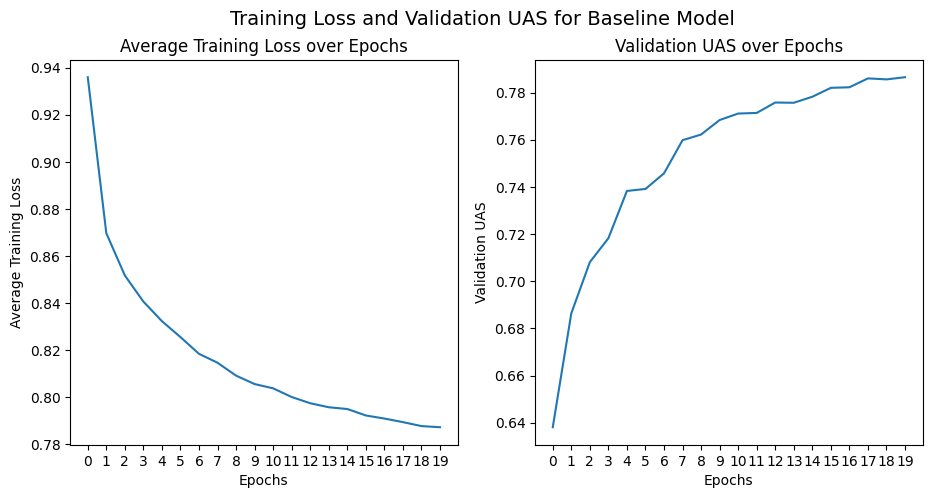

In [27]:
def plot_curves(title, train_curve, val_curve):
  """
  Plots the training loss and validation UAS over epochs.

  Args:
    title: title for the chart.
    train_curve: average training loss over epochs.
    val_curve: validation UAS over epochs.
  """

  figure, axis = plt.subplots(1, 2, figsize=(11, 5))

  axis[0].plot(train_curve)
  axis[0].set_xlabel('Epochs')
  axis[0].set_ylabel('Average Training Loss')
  axis[0].set_title('Average Training Loss over Epochs')
  axis[0].set_xticks(np.arange(20))

  axis[1].plot(val_curve)
  axis[1].set_xlabel('Epochs')
  axis[1].set_ylabel('Validation UAS')
  axis[1].set_title('Validation UAS over Epochs')
  axis[1].set_xticks(np.arange(20))

  figure.suptitle(title, fontsize=14)

  plt.subplots_adjust(wspace=0.2)
  plt.show()

# Load the learning curves.
path_bas_lc = os.path.join(BASELINE_PATH, 'curves.pkl')
with open(path_bas_lc, 'rb') as file:
    data = pickle.load(file)

if isinstance(data, dict) and 'avg_train_loss' in data and 'val_uas' in data:
    print('[INFO] Learning curves retrieved correctly.')
    all_avg_train_loss = data['avg_train_loss']
    all_val_uas = data['val_uas']
else:
    print('[ERROR] The pickle file does not contain the expected data structure.')

# Plot the learning curves.
plot_curves('Training Loss and Validation UAS for Baseline Model',
            all_avg_train_loss, all_val_uas)

Now, let's load the best model in terms of validation UAS.

In [28]:
# Get best model index
best_baseline_index = np.argmax(all_val_uas)
print(f'[INFO] Best baseline model has the index {best_baseline_index}.')

# Get best model path
path_bas_mod = os.path.join(BASELINE_PATH, f'model{best_baseline_index:02d}.yml')
print(f'[INFO] Loading from {path_bas_mod}.')

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_baseline_model = BaselineNet(device)
best_baseline_model.to(device)
# Comment one depending on CPU or GPU.
best_baseline_model.load_state_dict(torch.load(path_bas_mod))
#best_baseline_model.load_state_dict(torch.load(path_bas_mod, map_location=torch.device('cpu')))

[INFO] Best baseline model has the index 19.
[INFO] Loading from /content/drive/MyDrive/ESTUDIOS/2022-23/NaturalLanguageProcessing/Project/trained_models/baseline_conf5_lstm200_mlp200/model19.yml.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<All keys matched successfully>

### 5.2. Bert-based model

The following functions allow us to execute the training loop in the BERT-based model.

In [29]:
def bertbased_train(model, dataloader, criterion, optimizer, device):
  """
  BERT-based model's training function.
  """

  model.train()

  # All the batch losses in the epoch.
  losses = []

  for batch in tqdm(dataloader, '\tTraining epoch...', position=0, leave=True):

    optimizer.zero_grad()
    tokens, sentences, paths, moves, trees = batch # get a batch

    out = model(tokens, paths) # get a prediction

    labels = torch.tensor(sum(moves, [])).to(device) # flatten labels

    # Compute and save loss.
    loss = criterion(out, labels)
    losses.append(loss.item())

    # Backpropagation.
    loss.backward()
    optimizer.step()

  return losses

def bertbased_test(model, dataloader):
  """
  BERT-based model's test function.
  """

  model.eval()

  gold = []
  preds = []

  for batch in tqdm(dataloader, '\tTesting...', position=0, leave=True):

    tokens, sentences, paths, moves, trees = batch # get a batch

    with torch.no_grad():
      pred = model.infere(tokens, sentences)

      gold += trees
      preds += pred

  return evaluate(gold, preds)

In [30]:
# Path to save the model
BERTBASED_PATH = os.path.join(drive_path, 'MyDrive', 'ESTUDIOS', '2022-23',
                              'NaturalLanguageProcessing', 'Project',
                              'trained_models', 'bertbased_conf5_mlp600_avg')

# Create if it doesn't exist
if not os.path.exists(BERTBASED_PATH):
  print(f'[INFO] Creating folder {BERTBASED_PATH}.')
  os.makedirs(BERTBASED_PATH)

If we applied the classical ``torch.save`` function to our model, we will obtain a 400 MB file, because we would be saving all the weights of our BERT backbone too. As we are only fine-tuning some weights in the topmost layers (the rest of the weights are taken from BETO), we will save only these. For this, we need a different function.

In [31]:
def save_bertbased(model, path):
  """
  Saves the BertBasedNet weights.

  It avoids saving all the BERT backbone weights by only saving the weights of
  the topmost layers that have been fine-tuned.

  Args:
    model: needs to be a BertBasedNet object.
    path: path to save the model's weights.
  """

  parameters_to_save = {}
  for name, param in model.named_parameters():
      if not name.startswith('bert.') or name in ('bert.pooler.dense.bias', 'bert.pooler.dense.weight'):
          parameters_to_save[name] = param

  torch.save(parameters_to_save, path)

In [ ]:
##########################################
################ TRAINING ################
##########################################
# Select GPU device if possible.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
bertbased_model = BertBasedNet(device)
bertbased_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(bertbased_model.parameters(), lr=BERTBASED_LR)

all_avg_train_loss = [] # average training loss over epochs
all_val_uas = [] # validation UAS over epochs

for epoch in range(BERTBASED_EPOCHS):
  print(f'EPOCH {epoch}...')

  # Train the epoch.
  train_losses = bertbased_train(bertbased_model, train_dataloader, criterion, optimizer, device)

  # Compute average (in the epoch) training loss.
  avg_train_loss = np.mean(train_losses)
  all_avg_train_loss.append(avg_train_loss)

  # Compute validation UAS.
  val_uas = bertbased_test(bertbased_model, dev_dataloader)
  all_val_uas.append(val_uas)

  # Report
  print("\tEpoch results | avg_train_loss: {:5.3f} | dev_uas: {:5.3f} |".format(avg_train_loss, val_uas))

  # Save the model.
  path_bert_mod = os.path.join(BERTBASED_PATH, f'model{epoch:02d}.yml')
  print(f'\tSaving the model to {path_bert_mod}')
  save_bertbased(bertbased_model, path_bert_mod)

# Save learning curves.
path_bert_lc = os.path.join(BERTBASED_PATH, f'curves.pkl')
print(f'\tSaving leaning curves to {path_bert_lc}')
data = {
    'avg_train_loss': all_avg_train_loss,
    'val_uas': all_val_uas
}
with open(path_bert_lc, 'wb') as file:
    pickle.dump(data, file)

Now let's plot the training curves (training loss and validation UAS over epochs).

[INFO] Learning curves retrieved correctly.


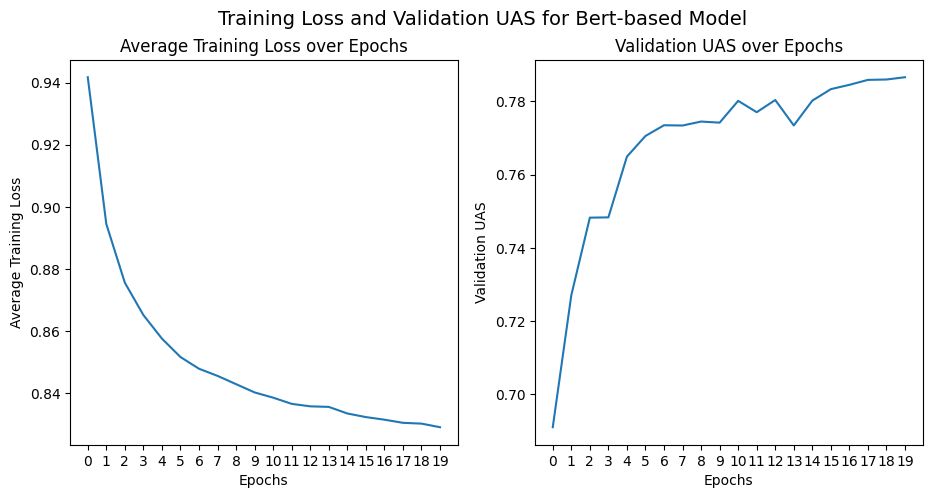

In [33]:
# Load the learning curves.
path_bert_lc = os.path.join(BERTBASED_PATH, 'curves.pkl')
with open(path_bert_lc, 'rb') as file:
    data = pickle.load(file)

if isinstance(data, dict) and 'avg_train_loss' in data and 'val_uas' in data:
    print('[INFO] Learning curves retrieved correctly.')
    all_avg_train_loss = data['avg_train_loss']
    all_val_uas = data['val_uas']
else:
    print('[ERROR] The pickle file does not contain the expected data structure.')

# Plot the learning curves.
plot_curves('Training Loss and Validation UAS for Bert-based Model',
            all_avg_train_loss, all_val_uas)

Now let's load the best model in terms of validation UAS.

In [34]:
# Get best model index.
bert_bertbased_index = np.argmax(all_val_uas)
print(f'[INFO] Best baseline model has the index {bert_bertbased_index}.')

# Get best model path.
path_bert_mod = os.path.join(BERTBASED_PATH, f'model{bert_bertbased_index:02d}.yml')
print(f'[INFO] Loading from {path_bert_mod}.')

# Load the model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_bertbased_model = BertBasedNet(device)
best_bertbased_model.to(device)
# IMPORTANT: the following line will print a large warning, as we are loading
# only some BERT weights (the ones optimized by us)
# Comment one depending on CPU or GPU.
best_bertbased_model.load_state_dict(torch.load(path_bert_mod), strict=False)
#best_bertbased_model.load_state_dict(torch.load(path_bert_mod, map_location=torch.device('cpu')), strict=False)

[INFO] Best baseline model has the index 19.
[INFO] Loading from /content/drive/MyDrive/ESTUDIOS/2022-23/NaturalLanguageProcessing/Project/trained_models/bertbased_conf5_mlp600_avg/model19.yml.


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.we

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids', 'bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.0.ou

The previous cell outputs a large warning, that warns us that only some of the model weights have been loaded from the file, this is the expected behaviour. Remember we only saved the weights that were fine-tuned by us (those from the topmost layers), the rest will be already initialized in BETO.

Some notes about the training process of both models:
- <u>Training time.</u> Using the Google Colab GPU acceleration, in both models each epoch takes approximately 3 minutes to train and 30 seconds to compute validation UAS. With 20 epochs, the whole training process takes about 70 minutes.
- <u>Extensive experiments</u>. A lot of experiments have been performed before reaching the final implementation decisions. We tried with several hyperparameter in order to achieve better results in terms of validation UAS. For example, we tested with the number of MLP layers, the number of parser configurations in the instances of the training data, different pre-trained Spanish BERT models...
- <u>Download the final models</u>. The final trained models can be found in a [Google Drive folder](https://drive.google.com/drive/folders/1gE7oKrTnzPiWqh-1f334A_3zHr5S3_fj?usp=sharing). Note that they contain all the different models over epochs and the learning curves.
- <u>Catastrophic forgetting</u>. At a certain point in the development of the project, we were stuck because the performance of the BERT-based model was too poor. We tried then to train the whole BERT backbone instead of doing fine-tuning in the topmost layers. This resulted in catastrophic forgetting producing a validation UAS much worse than the first obtained. Obviously, we decided to discard this implementation decision and try other methods.

## 6. Evaluation

### 6.1. Comparison between models

Once we have trained both models we are ready to evaluate them on the test set.

In some way, we have already performed some evaluation with the validation UAS curves. In this regard, both models yield very similar results, which is an  **unexpected result** as we presumed that the BERT-based model was going to outperform the baseline one since the training.

So, in order to get a definitive comparison between models, let's evaluate them on the test set.

In [35]:
print('BASELINE model:')
baseline_test_uas = baseline_test(best_baseline_model, test_dataloader)
print(f'\tTEST UAS = {baseline_test_uas}')

print('BERT-BASED model:')
bertbased_test_uas = bertbased_test(best_bertbased_model, test_dataloader)
print(f'\tTEST UAS = {bertbased_test_uas}')

BASELINE model:


	Testing...:   0%|          | 0/54 [00:00<?, ?it/s]

	TEST UAS = 0.7794170564951421
BERT-BASED model:


	Testing...:   0%|          | 0/54 [00:00<?, ?it/s]

	TEST UAS = 0.7868600973466412


On the test set, the BERT-based model slightly outperforms the baseline one (using Bi-LSTM).

We justify the result with the following reasons:
- The BERT model we have used is a transformer-based model that has been pretrained on a **massive amount of text data**. It has been shown to capture rich semantic and syntactic information from the text, making it a powerful language representation model. In contrast, Bi-LSTMs rely solely on the sequential information of the input, which may be limited.
- BERT generates contextualized word representations by considering the **entire input sentence** rather than relying solely on the left and right context like Bi-LSTMs. This contextualization allows BERT to capture dependencies and relationships between words more effectively.
- BERT utilizes **subword tokenization**, which can handle out-of-vocabulary (OOV) words and capture morphological information. Dependency parsing can benefit from this subword-level representation as it helps handle complex linguistic phenomena like word compounding, morphological variations, and rare words. Bi-LSTMs, which typically operate at the word level, may struggle to handle these phenomena effectively. In fact, in our baseline model, we have decided to substitute every word appearing less than 3 times in the dataset by the token *unk*. Especially in these cases, the BERT-based model can get a more rich embedding considering the token text.
- BERT employs a **self-attention** mechanism that allows it to capture long-range dependencies and focus on relevant contextual information. This attention mechanism helps BERT understand the relationships between different words in a sentence, which is crucial for dependency parsing.

### 6.2. Error analysis for the BERT-based model

To perform some error analysis for the BERT-based model we will create a reduced version of the dataset containing sentences with no more than 15 words.
The motivation behind limiting the sentences to a maximum of 15 words is to facilitate quick and efficient visualization.
We will only use the test split, for which we will create a dataloader.

In [36]:
# Reduced dataset
dataset_red = load_dataset('universal_dependencies', 'es_ancora')

def filter_sentence_length(example):
  if len(example['tokens']) <= 15:
    return True
  else: return False

# Apply the filter
dataset_red = {
    'train': dataset_pro['train'].filter(filter_sentence_length),
    'validation': dataset_pro['validation'].filter(filter_sentence_length),
    'test': dataset_pro['test'].filter(filter_sentence_length)}

# Show some statistics
dataset_statistics_by_splits(['train', 'validation', 'test'], dataset_red)

# Create dataloader
red_test_dataloader = torch.utils.data.DataLoader(dataset_red['test'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=partial(prepare_batch))

  0%|          | 0/3 [00:00<?, ?it/s]

╒══════════════════════╤═════════╤══════════════╤═════════╕
│ Measure              │   train │   validation │    test │
╞══════════════════════╪═════════╪══════════════╪═════════╡
│ Number of instances  │    2722 │          299 │     388 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length mean │ 9.94453 │      9.93311 │ 10.3299 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length max  │      15 │           15 │      15 │
├──────────────────────┼─────────┼──────────────┼─────────┤
│ Sentence length min  │       1 │            2 │       2 │
╘══════════════════════╧═════════╧══════════════╧═════════╛


Now, in order to get the predicted dependency trees (do inference), we need to develop a structure very similar to the one in the function ``bertbased_test``. We will save all the predicted dependency trees (variable ``predictions``) and all the predicted dependency trees that contain at least one error in  (``errors``).

Here, we represent each prediction with a triple containing the gold tree, the predicted tree, and the tokens' text.

In [37]:
best_bertbased_model.eval()

predictions = [] # predicted trees
errors = [] # erroneous predicted trees

for batch in tqdm(red_test_dataloader, '\tTesting...', position=0, leave=True):

  b_token, b_sentence, b_configurations, b_actions, b_gold = batch # get a batch

  with torch.no_grad():
    # get predicted tree
    b_output = best_bertbased_model.infere(b_token, b_sentence)

    for gold, pred, token in zip(b_gold, b_output, b_token):
      # save predicted tree
      predictions.append((gold, pred, token))
      if gold != pred:
        # save erroneous predicted tree
        errors.append((gold, pred, token))

	Testing...:   0%|          | 0/13 [00:00<?, ?it/s]

Now let's print the number of predicted trees, the number of incorrectly predicted trees (at least one error), and let's print all the erroneous trees.

In [38]:
print(f'Number of predicted dependency trees: {len(predictions)}')
print(f'Number of erroneous dependency trees: {len(errors)}')

def print_erroneous_tree(index, e_gold, e_pred, e_token):
  """
  Prints an erroneous dependency tree.

  Args:
    index: index of the tree in some data structure.
    e_gold: gold tree.
    e_pred: incorrectly predicted tree.
    e_token: token's text of all the words in the tree.
  """
  # Add 'ERR:' to the incorrect dependencies.
  e_pred_str = []
  for g, p in zip(e_gold, e_pred):
    if (g != p):
      e_pred_str.append('ERR:'+str(p))
    else:
      e_pred_str.append(str(p))

  print(f'#### ERROR {index} ####')

  # Create and show the table.
  tab_data = [['TOKENS:', '<ROOT>'] + e_token,
              ['INDEX:'] + [i for i in range(len(e_gold))],
              ['GOLD:'] + e_gold,
              ['OUTPUT:'] + e_pred_str]
  print(tabulate(tab_data, tablefmt="fancy_grid"))

for i, (e_gold, e_pred, e_token) in enumerate(errors):
  print_erroneous_tree(i, e_gold, e_pred, e_token)

Number of predicted dependency trees: 388
Number of erroneous dependency trees: 139
#### ERROR 0 ####
╒═════════╤════════╤════╤══════╤════╤════╤════════╤══════════╤═════╤════════════╤═══╤════════╤════╤═════╤════╤═══════════╤════╕
│ TOKENS: │ <ROOT> │ La │ rata │ es │ un │ animal │ clasista │ por │ naturaleza │ , │ hasta  │ en │ eso │ es │ asquerosa │ .  │
├─────────┼────────┼────┼──────┼────┼────┼────────┼──────────┼─────┼────────────┼───┼────────┼────┼─────┼────┼───────────┼────┤
│ INDEX:  │ 0      │ 1  │ 2    │ 3  │ 4  │ 5      │ 6        │ 7   │ 8          │ 9 │ 10     │ 11 │ 12  │ 13 │ 14        │ 15 │
├─────────┼────────┼────┼──────┼────┼────┼────────┼──────────┼─────┼────────────┼───┼────────┼────┼─────┼────┼───────────┼────┤
│ GOLD:   │ -1     │ 2  │ 5    │ 5  │ 5  │ 0      │ 5        │ 8   │ 5          │ 5 │ 12     │ 12 │ 14  │ 14 │ 5         │ 5  │
├─────────┼────────┼────┼──────┼────┼────┼────────┼──────────┼─────┼────────────┼───┼────────┼────┼─────┼────┼───────────┼────┤
│ 

In order to understand the errors is important to understand Spanish phrases. After a long analysis, we present the most common types of errors and some examples with English translations.

1. **Missing heads in the gold tree**.

At the initial stages of the project, when pre-processing the data, we realized that, in the gold trees of our dataset, there were some words whose head was set to 'None'. We decided to substitute this 'None' with the number -1, meaning that the dataset doesn't specify a head for this element.

For example, this happens in error number 3 (*But he has known how to do it from the front and with dignity*). The word *hacerlo* (*do it*) has the gold head -1, and our model assigns a label different from -1.
Another example is error number 131 (*Moving through an airport already costs work*), where we also find a word with gold head -1, the word *moverse* (*move*) where our model fails again.
Error number 128 (*Virtual visits can be made to the www.cambrallibrecat.com page*) is another example where the verb with gold head -1 is *hacerse*, which is decomposed into *hacer* and *se*.

Thanks to this error analysis we discovered that the words having a 'None' head contain Spanish clitics (for example *hacer-lo* or *mover-se*). We also discovered that in these cases, the following two words are the previous word decomposed (for example the word *hacerlo* has as following words *hacer* and *lo*).

In conclusion, our model has not been trained enough to detect this characteristic of the dataset. In a possible second version of the project, we could even consider eliminating this type of words from the sentences, maintaining only their decomposition present in the following words.

In [39]:
print_erroneous_tree(3, *errors[3])
print_erroneous_tree(131, *errors[131])
print_erroneous_tree(128, *errors[128])

#### ERROR 3 ####
╒═════════╤════════╤══════╤════╤════════╤═════════╤═══════╤═══════╤═══════╤════════╤════════╤════════╤══════════╤════╕
│ TOKENS: │ <ROOT> │ Pero │ ha │ sabido │ hacerlo │ hacer │ lo    │ de    │ frente │ y      │ con    │ dignidad │ .  │
├─────────┼────────┼──────┼────┼────────┼─────────┼───────┼───────┼───────┼────────┼────────┼────────┼──────────┼────┤
│ INDEX:  │ 0      │ 1    │ 2  │ 3      │ 4       │ 5     │ 6     │ 7     │ 8      │ 9      │ 10     │ 11       │ 12 │
├─────────┼────────┼──────┼────┼────────┼─────────┼───────┼───────┼───────┼────────┼────────┼────────┼──────────┼────┤
│ GOLD:   │ -1     │ 3    │ 3  │ 0      │ -1      │ 3     │ 4     │ 7     │ 4      │ 10     │ 10     │ 7        │ 3  │
├─────────┼────────┼──────┼────┼────────┼─────────┼───────┼───────┼───────┼────────┼────────┼────────┼──────────┼────┤
│ OUTPUT: │ -1     │ 3    │ 3  │ 0      │ ERR:3   │ ERR:4 │ ERR:5 │ ERR:8 │ ERR:6  │ ERR:11 │ ERR:11 │ ERR:8    │ 3  │
╘═════════╧════════╧══════╧═══

2. **The first verb in the sentence is set as the root child, even if it is not the principal**.

In dependency trees, the child of the *ROOT* element (the element having *ROOT* as father) is usually the principal verb of the sentence. In sentences where the principal verb doesn't appear the first, our model tends to set at the root child the first read verb, even if it is not the most important.

An example of this is error number 40 (*All it takes is a polo shirt and sweatpants to be appropriate, they pointed out*). The verb *Basta* (that could be traduced as *all it takes*) is the first verb of the sentence, but not the principal one. Our model sets it as *ROOT* child, i.e., head 0 (error, it has gold head 12). However, the principal verb is *señalaron* (*they pointed out*), which is at the end; it should have head 0 but our models assigns 1.

In [40]:
print_erroneous_tree(40, *errors[40])

#### ERROR 40 ####
╒═════════╤════════╤═══════╤════╤══════╤═══╤══════╤════════════╤════════════╤═══════╤═══════╤═══════════╤════╤═══════════╤═══════╕
│ TOKENS: │ <ROOT> │ Basta │ un │ polo │ y │ unos │ pantalones │ deportivos │ para  │ ir    │ apropiado │ ,  │ señalaron │ .     │
├─────────┼────────┼───────┼────┼──────┼───┼──────┼────────────┼────────────┼───────┼───────┼───────────┼────┼───────────┼───────┤
│ INDEX:  │ 0      │ 1     │ 2  │ 3    │ 4 │ 5    │ 6          │ 7          │ 8     │ 9     │ 10        │ 11 │ 12        │ 13    │
├─────────┼────────┼───────┼────┼──────┼───┼──────┼────────────┼────────────┼───────┼───────┼───────────┼────┼───────────┼───────┤
│ GOLD:   │ -1     │ 12    │ 3  │ 1    │ 6 │ 6    │ 3          │ 6          │ 10    │ 10    │ 1         │ 1  │ 0         │ 12    │
├─────────┼────────┼───────┼────┼──────┼───┼──────┼────────────┼────────────┼───────┼───────┼───────────┼────┼───────────┼───────┤
│ OUTPUT: │ -1     │ ERR:0 │ 3  │ 1    │ 6 │ 6    │ 3          │

3. **Head of prepositions**.

In the dependency trees from our dataset, the head of a preposition is normally associated with the nucleus of the noun phrase that follows it. Our model presents problems in doing this assignment.

For example, in error number 121 (*BBVA Portugal increased profits by 91% in 2000*) the head of the preposition *en* (*in*) is set to the index 3, instead of being set to the index 10, that is the noun of the following noun phrase.

In [41]:
print_erroneous_tree(121, *errors[121])

#### ERROR 121 ####
╒═════════╤════════╤══════╤══════════╤═════════╤═════╤════════════╤════╤═════╤═══════╤═══════╤════════╤════╕
│ TOKENS: │ <ROOT> │ BBVA │ Portugal │ aumentó │ los │ beneficios │ el │ 91% │ en    │ el    │ 2000   │ .  │
├─────────┼────────┼──────┼──────────┼─────────┼─────┼────────────┼────┼─────┼───────┼───────┼────────┼────┤
│ INDEX:  │ 0      │ 1    │ 2        │ 3       │ 4   │ 5          │ 6  │ 7   │ 8     │ 9     │ 10     │ 11 │
├─────────┼────────┼──────┼──────────┼─────────┼─────┼────────────┼────┼─────┼───────┼───────┼────────┼────┤
│ GOLD:   │ -1     │ 3    │ 1        │ 0       │ 5   │ 3          │ 7  │ 3   │ 10    │ 10    │ 3      │ 3  │
├─────────┼────────┼──────┼──────────┼─────────┼─────┼────────────┼────┼─────┼───────┼───────┼────────┼────┤
│ OUTPUT: │ -1     │ 3    │ 1        │ 0       │ 5   │ 3          │ 7  │ 3   │ ERR:3 │ ERR:8 │ ERR:11 │ 3  │
╘═════════╧════════╧══════╧══════════╧═════════╧═════╧════════════╧════╧═════╧═══════╧═══════╧════════╧════╛

4. **Setting the child of the root in copulas and non-copulas**.

We have mentioned that in our dataset dependency trees, the child of the root is usually the principal verb of the sentence, but in reality, this only applies to copulas (or copula sentences). In copulas (that joins the subject of a sentence or clause to a subject complement), on the other hand, the child of root is usually the noun of the subject complement (that is usually a noun phrase).

We have observed that our model has problems distinguishing between the two cases, and so, it has problems setting the root child to a verb or noun correctly.

Error number 5 (*The first of these was a motorcycle patented in 1885*) is a copula because it incorporates the verb *ser* (*to be*), which appears in the conjugated form *fue* (*he/she/it was*). As we can observe, the root child should be the noun of the subject complement noun phrase, *motocicleta* (*motorcycle*). However, our model does not even predict a root child (no element with head 0).

Error number 113 (*Tarragona fines 30 jet skis in 10 days*) is a non-copula as the principal verb is *multar* (*to fine*). The root child is set to the noun *dias* (*days*), instead of the principal verb *multa* (*fines*).
In error number 115 (*THE CRIME OF ROCÍO WANNINKHOF SHOCKED THE TOWN OF MIJAS*), another non-copula, the root child is set to the noun *CRIMEN* (*crime*) instead of the verb *CONMOCIONÓ* (*shocked*).

In [42]:
print_erroneous_tree(5, *errors[5])
print_erroneous_tree(113, *errors[113])
print_erroneous_tree(115, *errors[115])

#### ERROR 5 ####
╒═════════╤════════╤════╤═════════╤════╤═══════╤═════╤═════╤═════════════╤═══════════╤════╤══════╤═══════╕
│ TOKENS: │ <ROOT> │ El │ primero │ de │ éstos │ fue │ una │ motocicleta │ patentada │ en │ 1885 │ .     │
├─────────┼────────┼────┼─────────┼────┼───────┼─────┼─────┼─────────────┼───────────┼────┼──────┼───────┤
│ INDEX:  │ 0      │ 1  │ 2       │ 3  │ 4     │ 5   │ 6   │ 7           │ 8         │ 9  │   10 │ 11    │
├─────────┼────────┼────┼─────────┼────┼───────┼─────┼─────┼─────────────┼───────────┼────┼──────┼───────┤
│ GOLD:   │ -1     │ 2  │ 7       │ 4  │ 2     │ 7   │ 7   │ 0           │ 7         │ 10 │    8 │ 7     │
├─────────┼────────┼────┼─────────┼────┼───────┼─────┼─────┼─────────────┼───────────┼────┼──────┼───────┤
│ OUTPUT: │ -1     │ 2  │ ERR:-1  │ 4  │ 2     │ 7   │ 7   │ ERR:2       │ 7         │ 10 │    8 │ ERR:2 │
╘═════════╧════════╧════╧═════════╧════╧═══════╧═════╧═════╧═════════════╧═══════════╧════╧══════╧═══════╛
#### ERROR 113 ####

5. **Not predicting a root child**.

There are some cases, where our model predicts that there is no root child in the sentence, thus no word with head 0. This often happens in exclamatory or interrogative sentences.
As we have mentioned, our training data contained sentences with words with head -1 in the training data.
As we have commented, our model contained sentences with words with a -1 head in the training data.
Here again, we observe a consequence of our model not having correctly learned what it means to have a word with head -1.

In error number 105 (*With the government we have!*), the gold root child is the noun *Gobierno* (*government*), but our model does not predict any.

In [43]:
print_erroneous_tree(105, *errors[105])

#### ERROR 105 ####
╒═════════╤════════╤═══╤═════╤════╤══════════╤═════╤═════════╤═══╤═══╕
│ TOKENS: │ <ROOT> │ ¡ │ Con │ el │ Gobierno │ que │ tenemos │ ! │ . │
├─────────┼────────┼───┼─────┼────┼──────────┼─────┼─────────┼───┼───┤
│ INDEX:  │ 0      │ 1 │ 2   │ 3  │ 4        │ 5   │ 6       │ 7 │ 8 │
├─────────┼────────┼───┼─────┼────┼──────────┼─────┼─────────┼───┼───┤
│ GOLD:   │ -1     │ 4 │ 4   │ 4  │ 0        │ 6   │ 4       │ 4 │ 4 │
├─────────┼────────┼───┼─────┼────┼──────────┼─────┼─────────┼───┼───┤
│ OUTPUT: │ -1     │ 4 │ 4   │ 4  │ ERR:-1   │ 6   │ 4       │ 4 │ 4 │
╘═════════╧════════╧═══╧═════╧════╧══════════╧═════╧═════════╧═══╧═══╛


6. **Sentences that include proper nouns are catastrophic**.

We have observed that, in sentences where some proper nouns (especially than one) appear, our model tends to generate a catastrophic dependency tree.
We consider catastrophic those trees having the majority of dependencies incorrect.

Error number 135 (*The 1.1 Alstom workers in Santa Perpètua de Mogoda are disappointed*) contains some proper nouns: *Alstom*, *Santa Perpètua*, and *Mogoda*. It only generates 5/16 correct dependencies.

Error number 138 (*Gómez-Angulo also wanted to be forceful in his censure of the skier*) contains one proper noun, *Gómez-Angulo*, and also offers a catastrophic result with 2/12 correct dependencies.

In [44]:
print_erroneous_tree(135, *errors[135])
print_erroneous_tree(138, *errors[138])

#### ERROR 135 ####
╒═════════╤════════╤═════╤═════╤══════════════╤════╤════════╤═══════╤═══════╤═══════╤══════════╤═══════╤════════╤════════╤════════╤═══════════════╤═══════╕
│ TOKENS: │ <ROOT> │ Los │ 1.1 │ trabajadores │ de │ Alstom │ ,     │ en    │ Santa │ Perpètua │ de    │ Mogoda │ ,      │ están  │ decepcionados │ .     │
├─────────┼────────┼─────┼─────┼──────────────┼────┼────────┼───────┼───────┼───────┼──────────┼───────┼────────┼────────┼────────┼───────────────┼───────┤
│ INDEX:  │ 0      │ 1   │ 2   │ 3            │ 4  │ 5      │ 6     │ 7     │ 8     │ 9        │ 10    │ 11     │ 12     │ 13     │ 14            │ 15    │
├─────────┼────────┼─────┼─────┼──────────────┼────┼────────┼───────┼───────┼───────┼──────────┼───────┼────────┼────────┼────────┼───────────────┼───────┤
│ GOLD:   │ -1     │ 2   │ 3   │ 14           │ 5  │ 3      │ 8     │ 8     │ 5     │ 8        │ 11    │ 8      │ 8      │ 14     │ 0             │ 14    │
├─────────┼────────┼─────┼─────┼────────────

7. **Loads of errors if the child of root is wrongly set**.

Usually, punctuation symbols in sentences are children of the child of the root, i.e. they are children of the most important word in the sentence. This always happen with the period, for example. Therefore, if our model assigns an incorrect root's child, a lot of punctuation symbols will have an incorrect head assigned.

A clear example of this is error 97 (*-- What a debut! --*), where the word *debut* is predicted as the root's child (error), and all the hyphens and exclamation marks' heads are thus wrongly set.

This is not only true for punctuation marks. In error 124 (*A prisoner slits the throat of another in the infirmary of the Lleida prison*), incorrect assignment of the root's child entails that many other words, with head pointing to the former, are wrongly assigned too.

In [45]:
print_erroneous_tree(97, *errors[97])
print_erroneous_tree(124, *errors[124])

#### ERROR 97 ####
╒═════════╤════════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╤═══════╕
│ TOKENS: │ <ROOT> │ -     │ -     │ ¡     │ Vaya  │ debut │ !     │ -     │ -     │ .     │
├─────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ INDEX:  │ 0      │ 1     │ 2     │ 3     │ 4     │ 5     │ 6     │ 7     │ 8     │ 9     │
├─────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ GOLD:   │ -1     │ 4     │ 4     │ 4     │ 0     │ 4     │ 4     │ 4     │ 4     │ 4     │
├─────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│ OUTPUT: │ -1     │ ERR:5 │ ERR:5 │ ERR:5 │ ERR:5 │ ERR:0 │ ERR:5 │ ERR:5 │ ERR:5 │ ERR:5 │
╘═════════╧════════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╧═══════╛
#### ERROR 124 ####
╒═════════╤════════╤════╤═══════╤══════════╤═══════╤═══════╤════╤════╤════════════╤════╤════╤════════╤════╤════════╤═══════╕

## 7. Discussion of SotA

Remember that the test UAS for our baseline model was 0.779, and for the BERT-based 0.786.

#### Paper: Finding Dependency Parsing Limits over a Large Spanish Corpus

Initially, we were going to center the discussion of state-of-the-art dependency parsers for the Spanish Ancora corpus on the paper [Finding Dependency Parsing Limits over a Large Spanish Corpus](https://aclanthology.org/I13-1123.pdf) by Muntsa Padro, Miguel Ballesteros, Hector Martínez, and Bernd Bohnet. This word examined the performance of various parsers on extensive Spanish treebanks to determine the limitations of state-of-the-art parsers in 2013. Among others, they used the Tibidabo Treebank, which contains a set of sentences extracted from the Ancora corpus.

Unfortunately, they are addressing labeled dependency parsing, so the used evaluation metric was Labeled Attachment Score (LAS). This doesn't allow us to make a direct comparison with our results. Anyway, their results were the following.

<table>
  <tr>
    <th>Parser</th>
    <th>IULA Test LAS (%)</th>
    <th>Tibidabo LAS (%)</th>
  </tr>
  <tr>
    <td>Malt</td>
    <td>93.16</td>
    <td>89.04</td>
  </tr>
  <tr>
    <td>MST</td>
    <td>92.72</td>
    <td>89.36</td>
  </tr>
  <tr>
    <td>Mate-T</td>
    <td>94.47</td>
    <td>91.05</td>
  </tr>
  <tr>
    <td>Mate-C</td>
    <td>94.70</td>
    <td>91.43</td>
  </tr>
  <tr>
    <td>Mate-G</td>
    <td>94.49</td>
    <td>91.26</td>
  </tr>
</table>

We should focus on the *Tibidabo LAS* column. As we can see the best result is obtained with the parser *Mate-G* obtaining a LAS of 91.26, followed by *Mate-C* (91.43), and *Mate-T* (91.05).
These are results significantly better than ours since the LAS score is usually lower than the UAS.

Unlike us, they have not only used transition-based dependency parsers, *Mate-G* is a graph-based parser, *MateT* is a transition-based parser without graph-based re-scoring, and *Mate-C* is a transition-based parser with an enabled graph-based completion model. The diversity of their models, together with the use of a larger dataset for training justify their good performance.

After doing this analysis we realized that the dependency trees they were using to train their models were the Spanish Ancora ones, but not in the Universal Dependencies format.
In fact, the paper [Universal Dependencies for the AnCora treebanks](http://journal.sepln.org/sepln/ojs/ojs/index.php/pln/article/view/5341) by Héctor Martínez Alonso and Daniel Zeman explains the conversion process of this treebank to the UD formalism.
They conclude that the converted treebanks show an internal consistency comparable to other Spanish UD treebanks, so they have a high quality. An example of this conversion is in the following image.

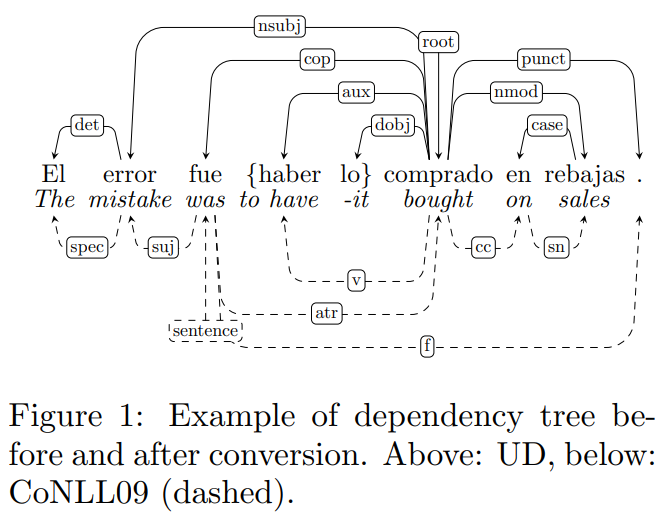

This fact led us to look for a leaderboard for the Universal Dependencies project.

### Dependency Parsing on Universal Dependencies

The leaderboard for dependency parsing on the whole Universal Dependencies dataset can be found [here](https://paperswithcode.com/sota/dependency-parsing-on-universal-dependencies?metric=UAS) and is the following.

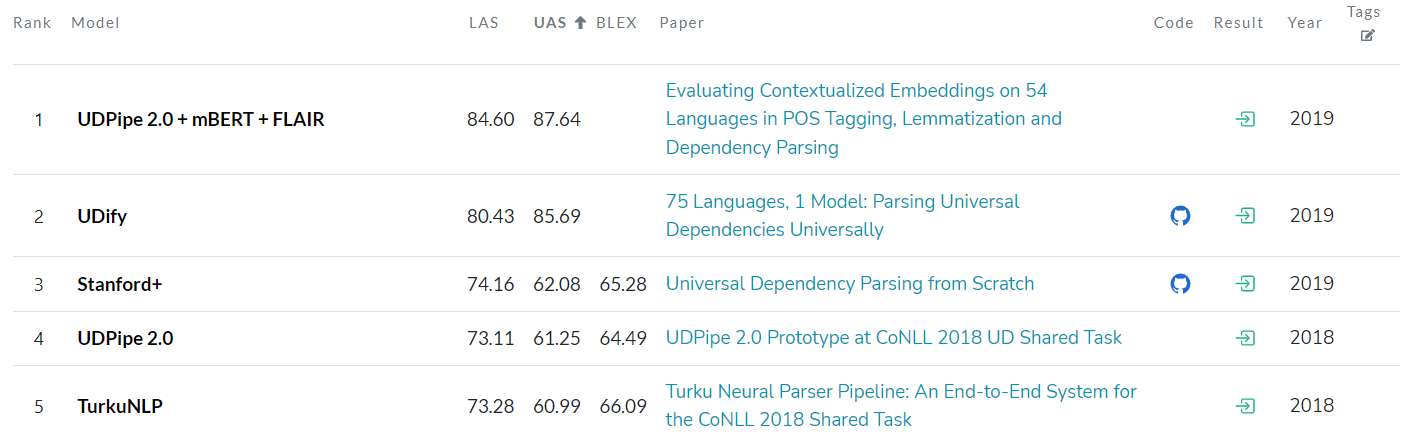

Please note that the results presented here are obtained from models trained not only on the Spanish Ancora dataset but also on various other treebanks, including those in languages other than Spanish. Despite this variation, these results provide us with an approximate measure of the current state-of-the-art performance we are aiming to assess.

At the time of writting, there are two models performing better in terms of UAS than our models: *UDPipe 2.0 + mBERT + FLAIR* (87.64), and *UDify* (85.69).

### Conclusion

This state-of-the-art analysis suggests that neither of our models performs particularly poorly compared to other projects.

In particular, between the two models developed, we would select the BERT-based model as the best, since it is the one that obtains the best results in the dataset test. The inclusion of BERT seems to have been a fundamental factor in capturing the context of words, an essential task for dependency parsing.

Likewise, the analysis performed affirms that our models are not the best and therefore still have a lot of room for improvement. Some of these possible improvements to this project could be to train our BERT-based model with more training data, to consider using a different BERT backbone than BETO and to pay more attention to the preprocessing of the learning set.